In [1]:
!nvidia-smi

Thu Sep 30 12:53:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   74C    P0    27W /  N/A |    148MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, pipeline, GPTNeoForCausalLM, GPT2Tokenizer, Trainer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity(transformers.logging.CRITICAL)

## Load Data

In [3]:
df = pd.read_csv('runs/06 Caleb Preprocessed/data.csv')
df.iloc[280]

sae     wish there had been more of the `` queen '' an...
aave    wish there'd been more of the `` queen '' and ...
Name: 280, dtype: object

## Load Model

In [4]:
PRE_TRAINED_MODEL_NAME = 'EleutherAI/gpt-neo-1.3B'
tokenizer = GPT2Tokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = GPTNeoForCausalLM.from_pretrained(PRE_TRAINED_MODEL_NAME).to("cuda:0")

## Choose Sequence Length

C:\Users\stwan\anaconda3\envs\Dialect_Prompts\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


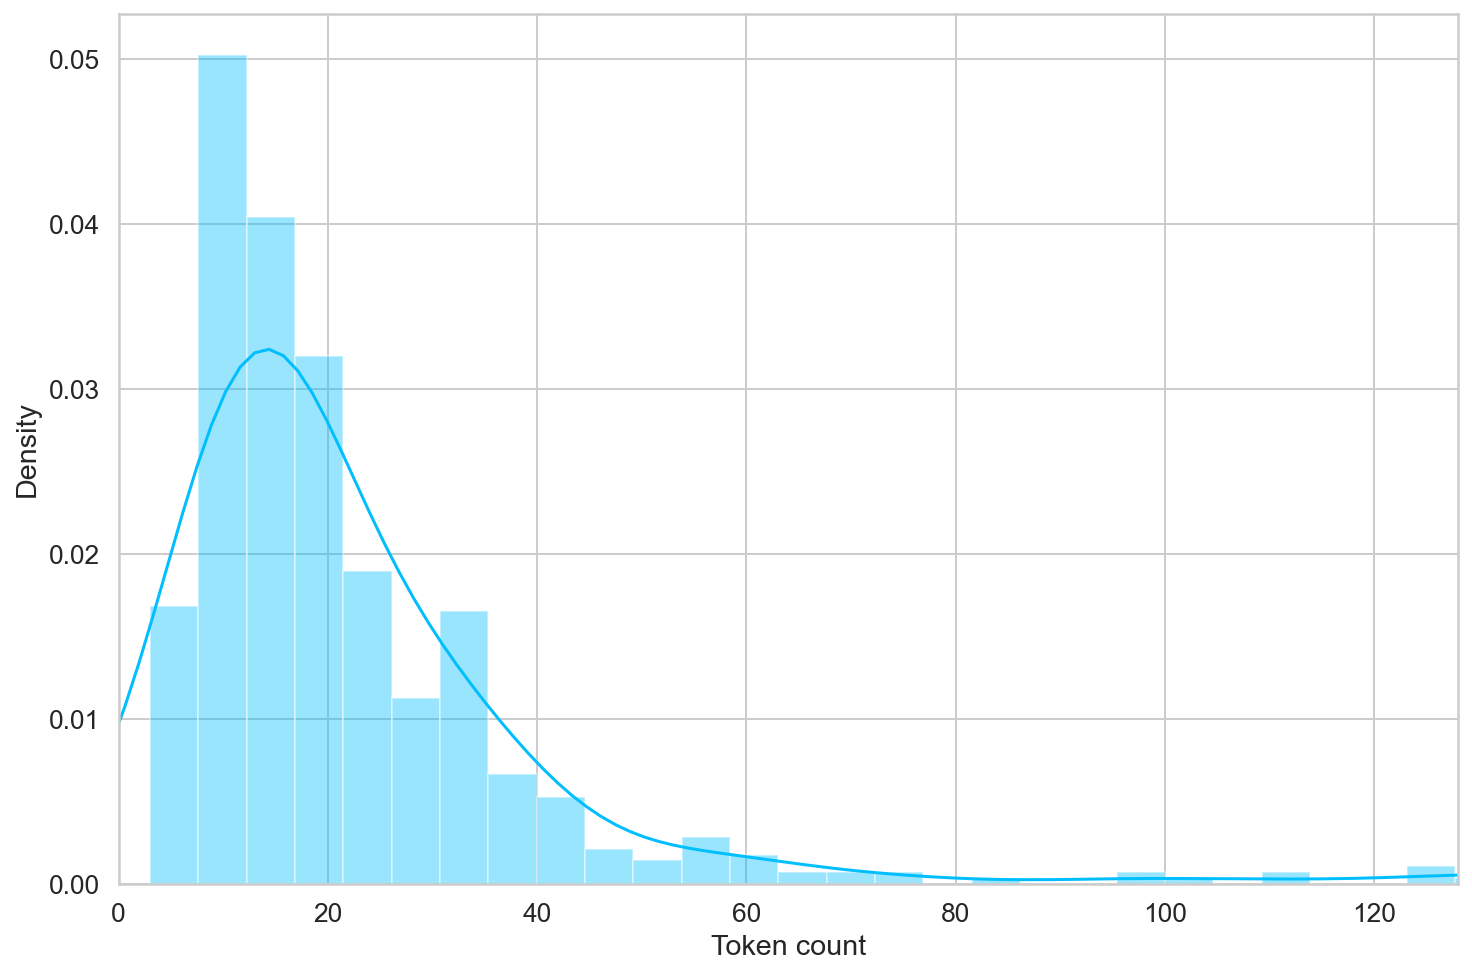

In [5]:
token_lens = []
for txt in df.sae:
    tokens = tokenizer.encode(txt, max_length=256)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

## Hyperparameters and Data Path

In [6]:
temp = [0.1, 0.5, 0.7, 1.0, 1.2, 1.5]
dialect = ['sae', 'aave']
second_seg_length = 'half' #split the setence in half
df = pd.read_csv('runs/06 Caleb Preprocessed/data.csv')

## Generation

In [7]:
for t in temp:
    print(f'Starting generation on temperature: {t}')
    output_sae = open('runs/06 Caleb Preprocessed/Generation/temp=' + str(t) + '/sae_gen_txt.csv', 'a', encoding="utf-8")
    output_aave = open('runs/06 Caleb Preprocessed/Generation/temp=' + str(t) + '/aave_gen_txt.csv', 'a', encoding="utf-8")
    writer_sae = csv.writer(output_sae)
    writer_aave = csv.writer(output_aave)
    for i in tqdm(range(df.shape[0])):
        txt_sae = df.iloc[i]['sae']
        txt_aave = df.iloc[i]['aave']
        input_ids_sae = tokenizer(txt_sae, return_tensors="pt").input_ids.cuda()
        if input_ids_sae.shape[1] > 10:
            input_ids_aave = tokenizer(txt_aave, return_tensors="pt").input_ids.cuda()
            
            split_idx_aave = int(input_ids_aave.shape[1] / 2)
            split_idx_sae = int(input_ids_sae.shape[1] / 2)
            
            gen_tokens_aave = model.generate(input_ids_aave[:, :split_idx_aave], do_sample=True, max_length=(input_ids_aave.shape[1]), temperature=t)
            gen_tokens_sae = model.generate(input_ids_sae[:, :split_idx_sae], do_sample=True, max_length=(input_ids_sae.shape[1]), temperature=t)
            
            prompt_aave = tokenizer.batch_decode(input_ids_aave[:, :split_idx_aave])
            prompt_sae = tokenizer.batch_decode(input_ids_sae[:, :split_idx_sae])
            
            prompt_cont_aave = tokenizer.batch_decode(input_ids_aave[:, split_idx_aave:])
            prompt_cont_sae = tokenizer.batch_decode(input_ids_sae[:, split_idx_sae:])
            
            gen_txt_aave = tokenizer.batch_decode(gen_tokens_aave[:, split_idx_aave:])
            gen_txt_sae = tokenizer.batch_decode(gen_tokens_sae[:, split_idx_sae:])
            
            writer_aave.writerow([i, prompt_aave[0], prompt_cont_aave[0], gen_txt_aave[0]])
            writer_sae.writerow([i, prompt_sae[0], prompt_cont_sae[0], gen_txt_sae[0]])

Starting generation on temperature: 0.1


100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [04:53<00:00,  2.10it/s]


Starting generation on temperature: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [04:56<00:00,  2.08it/s]


Starting generation on temperature: 0.7


100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [04:56<00:00,  2.08it/s]


Starting generation on temperature: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [04:55<00:00,  2.09it/s]


Starting generation on temperature: 1.2


100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [04:53<00:00,  2.10it/s]


Starting generation on temperature: 1.5


100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [04:50<00:00,  2.12it/s]
